# DEMO: Running FastCAM using SMOE Scale Saliency Maps

## Initial code setup

In [1]:
import os
import cv2
import numpy as np
import torch
from torchvision import models
from IPython.display import Image

Lets load things we need for **Grad-CAM**

In [2]:
from torchvision.utils import make_grid, save_image
import torch.nn.functional as F

from gradcam.utils import visualize_cam
from gradcam import GradCAMpp, GradCAM

# The GradCAM kit throws a warning we don't need to see for this demo. 
import warnings
warnings.filterwarnings('ignore')

Now we import the code for **this package**.

In [3]:
import maps
import mask
import draw
import norm
import misc

This is where we can set some parameters like the image name and the layer weights.

In [4]:
input_image_name    = "ILSVRC2012_val_00049934.224x224.png"     # Our input image to process 
output_dir          = 'outputs'                                 # Where to save our output images
input_dir           = 'images'                                  # Where to load our inputs from

weights             = [1.0, 1.0, 1.0, 1.0, 1.0]                 # Equal Weights work best 
                                                                # when using with GradCAM
    
#weights             = [0.18, 0.15, 0.37, 0.4, 0.72]            # Our saliency layer weights 
                                                                # From paper:
                                                                # https://arxiv.org/abs/1911.11293

save_prefix         = input_image_name[:-4].split('/')[-1]      # Chop the file extension and path
load_image_name     = os.path.join(input_dir, input_image_name)

os.makedirs(output_dir, exist_ok=True)

Good Doggy!

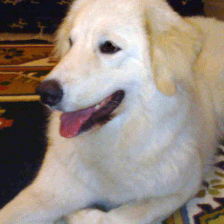

In [5]:
Image(filename=load_image_name) 

Now we create a model in PyTorch and send it to our device.

In [6]:
device              = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model               = models.resnet50(pretrained=True)
model               = model.to(device)

## Setting up Hooks
Now we will set up our layer hooks as callback methods. This will keep a copy of a layers output data from a forward pass. This is how we will get the data out of the network's layers. 

So, lets look at the second spatial scale of ResNet-50 which has three bottleneck layers. We want that very last ReLU at the very end. 

In [7]:
print("{}".format(model.layer1))

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, ke

<br>

**So...** we would select 

    model.layer1[2].relu
    
with a command like

    model.layer1[2].relu.register_forward_hook(hooks[1]) 
    
This attaches a callback which will store this layers output, when the network is run. 

Below we attach a hook at the end of each spatial scale. 

In [8]:
hooks   = [misc.CaptureLayerOutput() for i in range(5)]   # Create 5 callback hooks in a liszt
map_num = len(hooks)                                      # Store size for later use

# Chopin off the "_ =" is fine. We technically don't 
# need anything bach but the handel to each hook. 
_ = model.relu.register_forward_hook(hooks[0])
_ = model.layer1[2].relu.register_forward_hook(hooks[1])
_ = model.layer2[3].relu.register_forward_hook(hooks[2])
_ = model.layer3[5].relu.register_forward_hook(hooks[3])
_ = model.layer4[2].relu.register_forward_hook(hooks[4])

Notice that the layers we access are the same as in the resnet50 python model layers specificiation which is **[3, 4, 6, 3]**, we just subtract 1 from each. 

OK, now let's load in our image and set it to the standard *ImageNet* size: 224x224. 

In [9]:
in_tensor   = misc.LoadImageToTensor(load_image_name, device)
in_tensor   = F.interpolate(in_tensor, size=(224, 224), mode='bilinear', align_corners=False)

in_height   = in_tensor.size()[2]
in_width    = in_tensor.size()[3]

OK, let's run our ResNet network *forward only*. The callbacks will then contain the layer data afterwards. Since we are only doing a forward computation, this sails on a CPU. 

In [10]:
model.eval()
with torch.set_grad_enabled(False):
    _ = model(in_tensor)

## Running saliency on our network data

Now that the network has run, we can finally do some work. First we create objects for our saliency layers. These are *PyTorch nn layers*, but we can talk to them even if they are not inside a network. 

All three objects here are technically layers. So, they can be used inside your network as well. 

If you want to use these **inside your network**:

example, in your __init__ something like:

    self.salmap_layer     = maps.SMOEScaleMap()

then in forward(x) something like:

    x = self.relu(x)
    x = self.salmap_layer(x)

First, we create an object to get each saliency map given the data stored in the hooks. This will run SMOE Scale on each of the layer hook outputs and produce raw a saliency map. This package also includes code for using *Standard Deviation* or *Truncated Normal Entropy*. 

In [11]:
getSmap     = maps.SMOEScaleMap()

This next object will normalize the saliency maps from 0 to 1 using a Gaussian CDF squashing function.

In [12]:
getNorm     = norm.GammaNorm2D()  

Now we will create an object to combine the five saliency maps from each scale into one.

In [13]:
getCsmap    = maps.CombineSaliencyMaps(output_size=[in_height,in_width], 
                                       map_num=map_num, weights=weights, resize_mode='bilinear') 

Once we have our objects, we will run SMOE Scale on each of the output hooks and then normalize the output. 

In [14]:
smaps       = [ getNorm(getSmap(x.data)) for x in hooks ]           

Now, we combine the different saliency maps into a single combined saliency map. Notice that we also get back each saliency map in *smaps* rescaled by the method. 

In [15]:
csmap,smaps = getCsmap(smaps)

Then we save and view it.

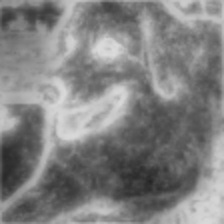

In [16]:
output_name = "{}.MAP_COMBINED.jpg".format(save_prefix)
output_path = os.path.join(output_dir, output_name)
misc.SaveGrayTensorToImage(csmap, output_path)
np_smaps    = misc.TensorToNumpyImages(smaps) # For later use, keep the Numpy version 
                                              # of the saliency maps.

Image(filename=output_path) 

Now lets get our individual saliency maps for each of the five layers and look at them. 

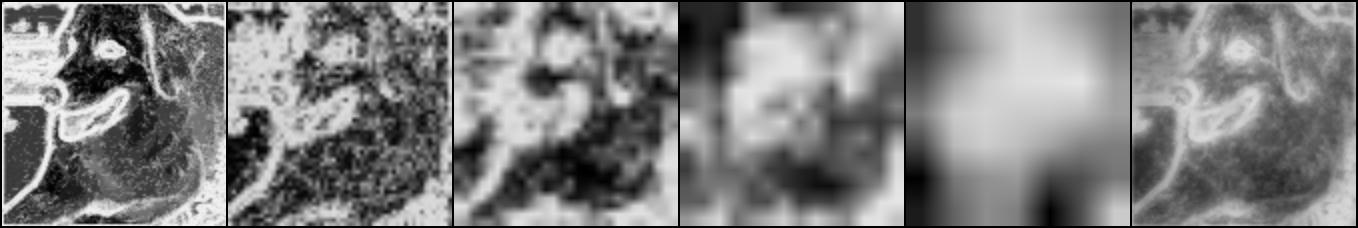

In [17]:
il = [smaps[0,i,:,:] for i in range(map_num)] # Put each saliency map into the figure
    
il.append(csmap[0,:,:])                       # add in the combined map at the end of the figure

images        = [torch.stack(il, 0)]          
images        = make_grid(torch.cat(images, 0), nrow=5)
output_name   = "{}.SAL_MAPS.jpg".format(save_prefix)
sal_img_file  = os.path.join(output_dir, output_name)

save_image(images.unsqueeze(1), sal_img_file)

Image(filename=sal_img_file) 

## LOVI and Heat Maps
Now we will take our saliency maps and create the LOVI and Heat Map versions.

In [18]:
SHM         = draw.HeatMap(shape=np_smaps.shape, weights=weights )  # Create our heat map drawer
LOVI        = draw.LOVI(shape=np_smaps.shape, weights=None)         # Create out LOVI drawer

shm_im      = SHM.make(np_smaps)                                    # Combine the saliency maps 
                                                                    # into one heat map
lovi_im     = LOVI.make(np_smaps)                                   # Combine the saliency maps 
                                                                    # into one LOVI image

Next, save and display our images. 

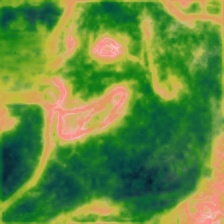

In [19]:
output_name = "{}.HEAT.jpg".format(save_prefix)
output_path = os.path.join(output_dir, output_name)
cv2.imwrite(output_path, (shm_im*255.0).astype(np.uint8))

Image(filename=output_path) 

Let's create on overlay with our original image by alpha blending. 

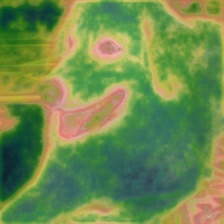

In [20]:
cv_im         = cv2.imread(load_image_name).astype(np.float32) / 255.0
cv_im         = cv2.resize(cv_im, (224,224))
ab_shm        = misc.AlphaBlend(shm_im, cv_im) # Blend the heat map and the original image

output_name   = "{}.ALPHA_HEAT.jpg".format(save_prefix)
output_path   = os.path.join(output_dir, output_name)
cv2.imwrite(output_path, (ab_shm*255.0).astype(np.uint8)) 

Image(filename=output_path) 

Now we view our LOVI map with and without alpha blending of the original image. The LOVI image tells us which parts of the network are most active by layer. We range like a rainbow with violet/blue representing early layers and yellow/red representing later layers. White areas are active over all layers. 

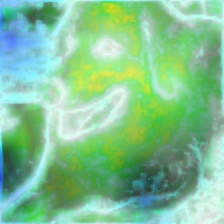

In [21]:
output_name   = "{}.LOVI.jpg".format(save_prefix)
output_path   = os.path.join(output_dir, output_name)
cv2.imwrite(output_path, (lovi_im*255.0).astype(np.uint8))

Image(filename=output_path) 

You can see how this image is composed by looking again at all the individual saliency maps...

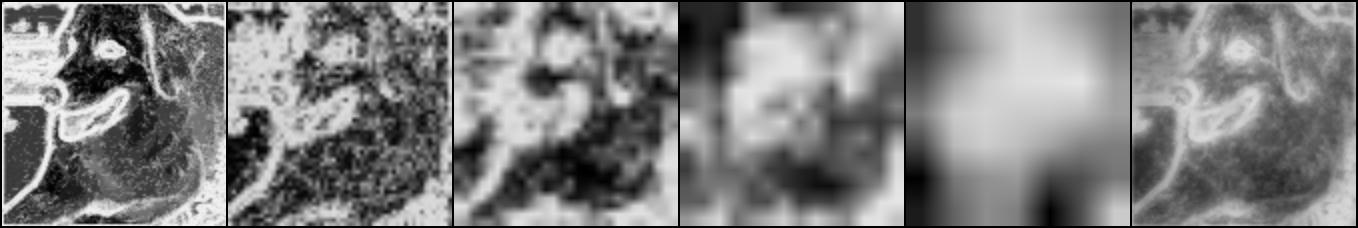

In [22]:
Image(filename=sal_img_file)

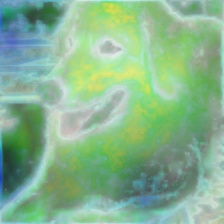

In [23]:
ab_lovi       = misc.AlphaBlend(lovi_im, cv_im) # Blend original image and LOVI image

output_name   = "{}.ALPHA_LOVI.jpg".format(save_prefix)
output_path   = os.path.join(output_dir, output_name)
cv2.imwrite(output_path, (ab_lovi*255.0).astype(np.uint8)) 

Image(filename=output_path) 

## The Masked Image
From the combined saliency map, we can extract the masked out input image. This illustrates What parts of the image are the top xx% most salient. 

First we set up objects to create the mask from the input tensor version of the image and the combined saliency map.

In [24]:
getMask                 = mask.SaliencyMaskDropout(keep_percent = 0.1, scale_map=False)

We define a denormalization object to get things back to normal image pixel values. 

In [25]:
denorm                  = misc.DeNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

Next we process the tensor and saliency map to create the masked image.  

In [26]:
masked_tensor,drop_map  = getMask(in_tensor, csmap)

Finally, we denormalize the tensor image, save and display it. This shows us the **top 10% most salient parts** of the images.

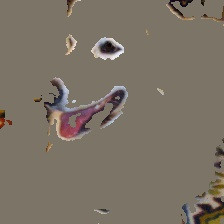

In [27]:
masked_tensor = denorm(masked_tensor)

output_name   = "{}.MASK.jpg".format(save_prefix)
output_path   = os.path.join(output_dir, output_name)
misc.SaveColorTensorToImage(masked_tensor, output_path)
Image(filename=output_path) 

## Run With Grad-CAM++

Let's go ahead and push our network model into the Grad-CAM library.

**NOTE** much of this code is borrowed from the Pytorch GradCAM package. 

In [28]:
resnet_gradcampp4   = GradCAMpp.from_config(model_type='resnet', arch=model, layer_name='layer4')

Let's get our original input image back.

In [29]:
raw_tensor   = misc.LoadImageToTensor(load_image_name, device, norm=False)
raw_tensor   = F.interpolate(raw_tensor, size=(224, 224), mode='bilinear', align_corners=False)

Now we will create illustrations of the combined saliency map. 

In [30]:
masked_tensor_raw,drop_map = getMask(raw_tensor, csmap)

cs_heatmap, cs_result      = visualize_cam(csmap, raw_tensor)
cs_masked                  = misc.AlphaMask(raw_tensor, csmap).squeeze(0)
cs_masked                  = misc.RangeNormalize(cs_masked)

images = []
images.append(torch.stack([raw_tensor.squeeze().cpu(), cs_heatmap.cpu(), 
                           cs_result.cpu(), cs_masked.cpu(), masked_tensor_raw[0,].cpu()], 0))

Now, lets get the Grad-CAM++ saliency map only.

In [31]:
mask_pp1, logit             = resnet_gradcampp4(in_tensor)

Let's double check and make sure it's picking the correct class

In [32]:
too_logit = logit.max(1)
print("Network Class Output: {} : Value {} ".format(too_logit[1][0],too_logit[0][0]))

Network Class Output: 222 : Value 16.058656692504883 


Now visualize the results

In [33]:
heatmap_pp1, result_pp1 = visualize_cam(mask_pp1, raw_tensor)

hard_masked_pp1,_       = getMask(raw_tensor, mask_pp1.squeeze(0))
hard_masked_pp1         = hard_masked_pp1.squeeze(0)
masked_pp1              = misc.AlphaMask(raw_tensor, mask_pp1.squeeze(0)).squeeze(0)
masked_pp1              = misc.RangeNormalize(masked_pp1)

images.append(torch.stack([raw_tensor.squeeze().cpu(), heatmap_pp1.cpu(), 
                           result_pp1.cpu(), masked_pp1.cpu(), hard_masked_pp1.cpu()], 0))

**Now we combine the Grad-CAM map and the SMOE Scale saliency maps** in the same way we would combine Grad-CAM with Guided Backprop.

In [34]:
mask_pp2                = csmap*mask_pp1

Now let's visualize the combined saliency map from SMOE Scale and GradCAM++.

In [35]:
heatmap_pp2, result_pp2 = visualize_cam(mask_pp2, raw_tensor)

hard_masked_pp2,_       = getMask(raw_tensor,mask_pp2.squeeze(0))
hard_masked_pp2         = hard_masked_pp2.squeeze(0)
masked_pp2              = misc.AlphaMask(raw_tensor, mask_pp2.squeeze(0)).squeeze(0)
masked_pp2              = misc.RangeNormalize(masked_pp2)

images.append(torch.stack([raw_tensor.squeeze().cpu(), heatmap_pp2.cpu(), 
                           result_pp2.cpu(), masked_pp2.cpu(), hard_masked_pp2.cpu()], 0))

Now we combine the Grad-CAM map and the SMOE Scale saliency maps but create a map of the **non-class** objects. These are salient locations that the network found interesting, but are not part of the object class. 

In [36]:
mask_pp3                = csmap*(1.0 - mask_pp1)

Now let's visualize the combined non-class saliency map from SMOE Scale and GradCAM++.

In [37]:
heatmap_pp3, result_pp3 = visualize_cam(mask_pp3, raw_tensor)

hard_masked_pp3,_       = getMask(raw_tensor,mask_pp3.squeeze(0))
hard_masked_pp3         = hard_masked_pp3.squeeze(0)
masked_pp3              = misc.AlphaMask(raw_tensor, mask_pp3.squeeze(0)).squeeze(0)
masked_pp3              = misc.RangeNormalize(masked_pp3)

images.append(torch.stack([raw_tensor.squeeze().cpu(), heatmap_pp3.cpu(), 
                           result_pp3.cpu(), masked_pp3.cpu(), hard_masked_pp3.cpu()], 0))

We now put all the images into a nice grid for display.

In [38]:
images = make_grid(torch.cat(images,0), nrow=5)

... save and look at it. 

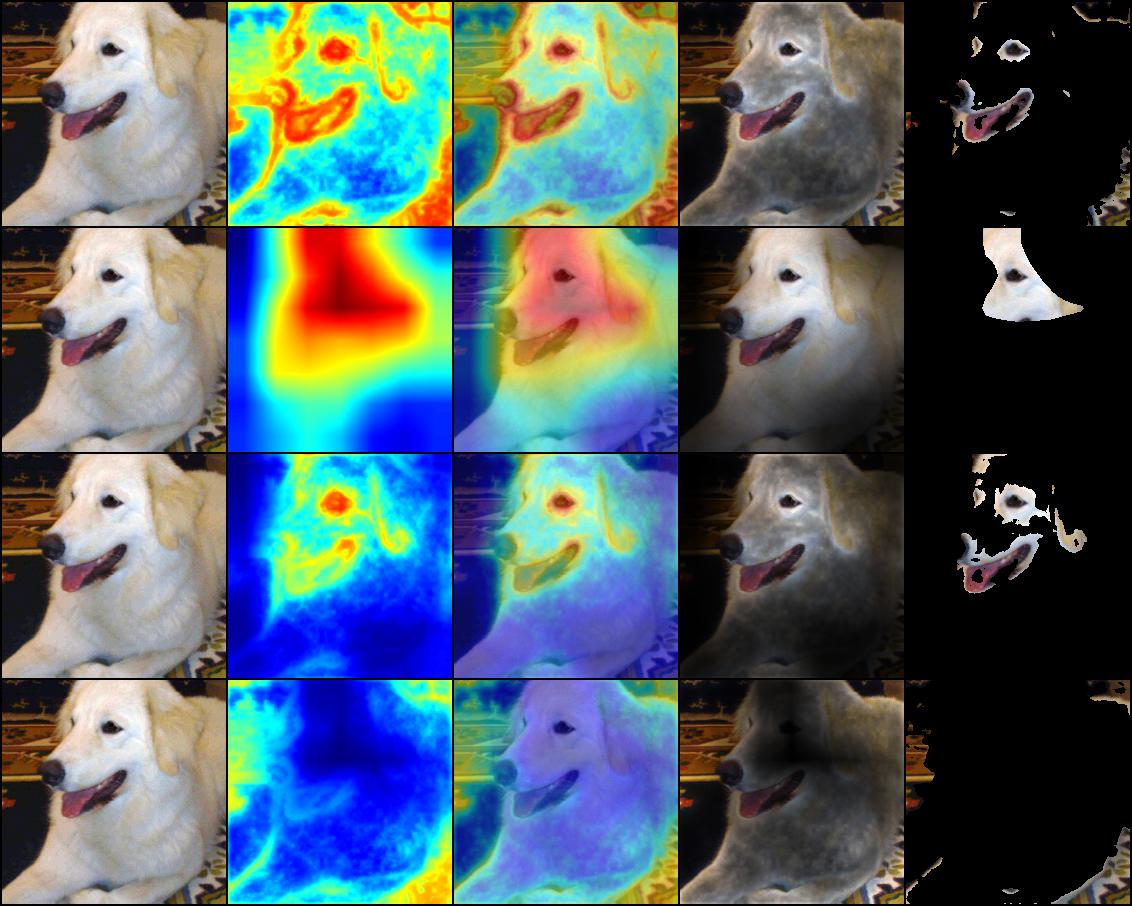

In [39]:
output_name = "{}.CAM_PP.jpg".format(save_prefix)
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
Image(filename=output_path) 

The top row is the SMOE Scale based saliency map. The second row is GradCAM++ only. Next we have the FastCAM output from combining the two. The last row is the non-class map showing salient regions that are not associated with the output class.

This image should look **exactly** like the one on the README.md on Github minus the text. 